In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import xgboost as xgb
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score

In [2]:
# Load your original dataset (without modifying it)
original_data = pd.read_csv(r"C:\Users\sneha\Downloads\COE_PROJ\Data\cleaned_dataset.csv")

# Get unique User IDs dynamically
unique_users = original_data['User_ID'].unique()
print("Total Users:", len(unique_users))

Total Users: 19986


In [3]:
# Ensure debt ratio exists (if missing, assume debt = 0 for simplicity)
if 'Debt_to_Income_Ratio' not in original_data.columns:
    original_data['Debt_to_Income_Ratio'] = np.random.uniform(0, 0.5, len(original_data))

In [4]:
# ------------------ Create Separate Variable for Financial Health Tracking ------------------ #
expanded_data = []  # New dataset without modifying original one
dates = pd.date_range(start="2023-01-01", periods=12, freq='ME')  # Monthly timestamps

for user in unique_users:
    for date in dates:
        user_data = original_data[original_data['User_ID'] == user].iloc[0]  # Get single record

        # Generate financial variations dynamically
        expanded_data.append({
            'User_ID': user,
            'Date': date,
            'Income': user_data['Income'] * np.random.uniform(0.95, 1.05),
            'Disposable_Income': user_data['Disposable_Income'] * np.random.uniform(0.9, 1.1),
            'Essential_Expenses': user_data['Essential_Expenses'] * np.random.uniform(0.95, 1.05),
            'Non_Essential_Expenses': user_data['Non_Essential_Expenses'] * np.random.uniform(0.9, 1.1),
            'Total_Expenses_to_Income_Ratio': user_data['Total_Expenses_to_Income_Ratio'] * np.random.uniform(0.95, 1.05),
            'Desired_Savings_Percentage': user_data['Desired_Savings_Percentage'],
            'Savings_Efficiency': user_data['Savings_Efficiency'] * np.random.uniform(0.9, 1.1),
            'Debt_to_Income_Ratio': user_data['Debt_to_Income_Ratio'],
            'Financial_Health_Score': (
                (0.35 * user_data['Savings_Efficiency']) +
                (0.25 * (1 - user_data['Total_Expenses_to_Income_Ratio'])) +
                (0.20 * user_data['Disposable_Income'] / user_data['Income']) +
                (0.20 * (1 - user_data['Debt_to_Income_Ratio']))
            ) * 100  # Scale to range 0-100
        })

In [5]:
# Convert list into DataFrame for financial tracking
financial_history_data = pd.DataFrame(expanded_data)
financial_history_data['Financial_Health_Score'] *= np.random.uniform(0.95, 1.05, len(financial_history_data))
print(financial_history_data.head())  # Preview data

   User_ID       Date        Income  Disposable_Income  Essential_Expenses  \
0        1 2023-01-31  44605.015540       11418.677114        25615.336720   
1        1 2023-02-28  42824.475584       11912.741556        24886.434820   
2        1 2023-03-31  45715.617944       11659.049655        23440.062063   
3        1 2023-04-30  44354.709721       11426.527748        23517.545672   
4        1 2023-05-31  43302.928424       10348.261857        25193.093514   

   Non_Essential_Expenses  Total_Expenses_to_Income_Ratio  \
0             3939.709389                        0.698798   
1             4014.656140                        0.696740   
2             4052.505575                        0.728591   
3             3727.839254                        0.693834   
4             4342.920563                        0.702419   

   Desired_Savings_Percentage  Savings_Efficiency  Debt_to_Income_Ratio  \
0                   13.890948            0.269667               0.02917   
1             

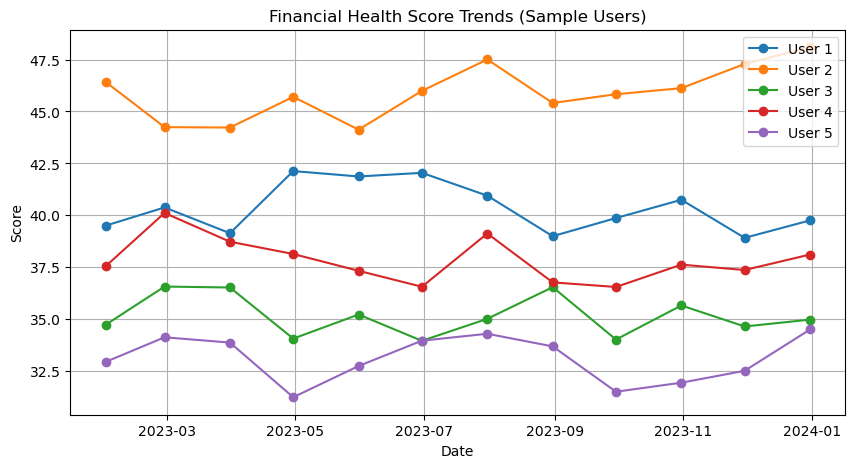

In [6]:
# ------------------ Visualization 1: Financial Health Score Trends Over Time ------------------ #
plt.figure(figsize=(10, 5))

for user in unique_users[:5]:  # Limit visualization to 5 users
    user_records = financial_history_data[financial_history_data['User_ID'] == user]
    plt.plot(user_records['Date'], user_records['Financial_Health_Score'], marker='o', linestyle='-', label=f"User {user}")

plt.title("Financial Health Score Trends (Sample Users)")
plt.xlabel("Date")
plt.ylabel("Score")
plt.legend()
plt.grid()
plt.show()

In [7]:
# ------------------ Prepare Data for XGBoost Model ------------------ #
features = ['Income', 'Disposable_Income', 'Essential_Expenses', 'Non_Essential_Expenses',
            'Total_Expenses_to_Income_Ratio', 'Desired_Savings_Percentage', 'Savings_Efficiency',
            'Debt_to_Income_Ratio']

X = financial_history_data[features]  # Use the separate financial tracking dataset
y = financial_history_data['Financial_Health_Score']

# Split data into training and test sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

In [8]:
# ------------------ Train XGBoost Model ------------------ #
xgb_model = xgb.XGBRegressor(objective='reg:squarederror', n_estimators=100, max_depth=5, learning_rate=0.1)
xgb_model.fit(X_train, y_train)

XGBRegressor(base_score=None, booster=None, callbacks=None,
             colsample_bylevel=None, colsample_bynode=None,
             colsample_bytree=None, device=None, early_stopping_rounds=None,
             enable_categorical=False, eval_metric=None, feature_types=None,
             feature_weights=None, gamma=None, grow_policy=None,
             importance_type=None, interaction_constraints=None,
             learning_rate=0.1, max_bin=None, max_cat_threshold=None,
             max_cat_to_onehot=None, max_delta_step=None, max_depth=5,
             max_leaves=None, min_child_weight=None, missing=nan,
             monotone_constraints=None, multi_strategy=None, n_estimators=100,
             n_jobs=None, num_parallel_tree=None, ...)

In [9]:
# ------------------ Predict Financial Health Score ------------------ #
y_pred = xgb_model.predict(X_test)

# Create DataFrame of actual vs predicted scores
results_df = pd.DataFrame({'Actual_Score': y_test, 'Predicted_Score': y_pred})
print(results_df.head())

        Actual_Score  Predicted_Score
117929     47.744788        47.790565
49284      39.440950        39.523499
103872     41.778989        41.381165
112802     28.778679        27.755627
152082     36.915652        36.583729


In [10]:
# ------------------ Evaluation Metrics ------------------ #
mae = mean_absolute_error(y_test, y_pred)
mse = mean_squared_error(y_test, y_pred)
rmse = np.sqrt(mse)
r2 = r2_score(y_test, y_pred)

print(f"Mean Absolute Error (MAE): {mae:.4f}")
print(f"Mean Squared Error (MSE): {mse:.4f}")
print(f"R² Score: {r2:.4f}")

Mean Absolute Error (MAE): 1.0995
Mean Squared Error (MSE): 1.8716
R² Score: 0.9725


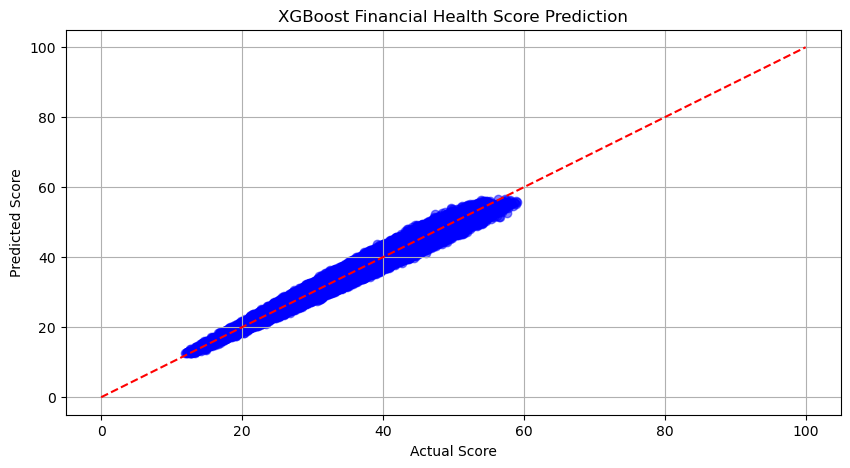

In [11]:
# ------------------ Visualization 2: Actual vs. Predicted Scores ------------------ #
plt.figure(figsize=(10, 5))
plt.scatter(y_test, y_pred, alpha=0.5, color='blue')
plt.plot([0, 100], [0, 100], linestyle="--", color="red")  # Reference line
plt.title("XGBoost Financial Health Score Prediction")
plt.xlabel("Actual Score")
plt.ylabel("Predicted Score")
plt.grid()
plt.show()

In [12]:
# ------------------ Future Financial Health Predictions Using XGBoost ------------------ #
future_data = financial_history_data.sample(n=5)[features]  # Select random users for future prediction
future_predictions = xgb_model.predict(future_data)

# Convert predictions into a DataFrame
future_predictions_df = pd.DataFrame({'User_ID': financial_history_data.sample(n=5)['User_ID'],
                                      'Predicted_Financial_Health_Score': future_predictions})
print(future_predictions_df)

        User_ID  Predicted_Financial_Health_Score
119602     9967                         36.817402
129508    10793                         25.017923
222935    18578                         40.728317
235159    19597                         44.371529
38696      3225                         38.270531


                          Feature  Importance
6              Savings_Efficiency    0.604767
4  Total_Expenses_to_Income_Ratio    0.291031
7            Debt_to_Income_Ratio    0.100076
1               Disposable_Income    0.001172
0                          Income    0.001170
2              Essential_Expenses    0.001136
3          Non_Essential_Expenses    0.000501
5      Desired_Savings_Percentage    0.000147


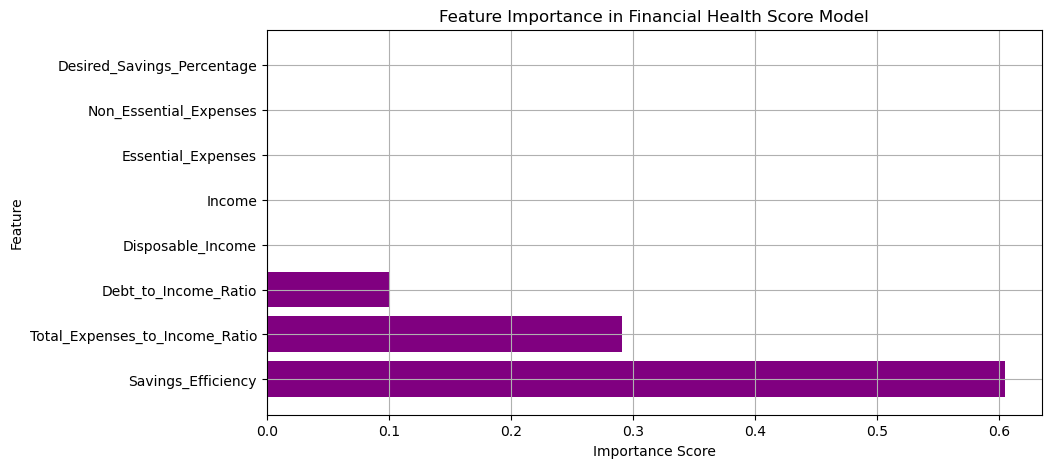

In [13]:
# ------------------ Feature Importance Analysis ------------------ #
importance_df = pd.DataFrame({'Feature': X_train.columns, 'Importance': xgb_model.feature_importances_})
importance_df = importance_df.sort_values(by='Importance', ascending=False)

print(importance_df)

# Plot feature importance
plt.figure(figsize=(10, 5))
plt.barh(importance_df['Feature'], importance_df['Importance'], color='purple')
plt.xlabel("Importance Score")
plt.ylabel("Feature")
plt.title("Feature Importance in Financial Health Score Model")
plt.grid()
plt.show()

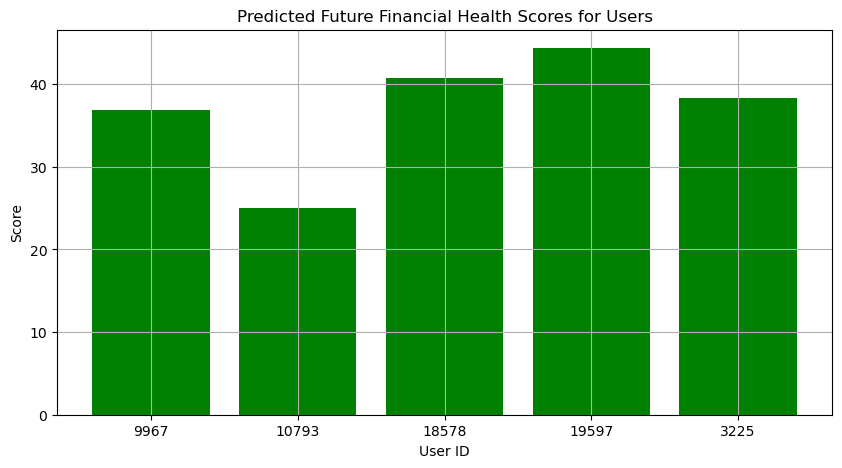

In [14]:
# ------------------ Visualization 3: Predicted Future Financial Health Scores ------------------ #
plt.figure(figsize=(10, 5))
plt.bar(future_predictions_df['User_ID'].astype(str), future_predictions_df['Predicted_Financial_Health_Score'], color='green')
plt.title("Predicted Future Financial Health Scores for Users")
plt.xlabel("User ID")
plt.ylabel("Score")
plt.grid()
plt.show()

In [15]:
def plot_financial_health(user_id, history_data, predictions_data):
    """
    Generate financial health score visualization for a given User ID.

    Parameters:
    - user_id: ID of the user to visualize
    - history_data: DataFrame containing past financial health scores
    - predictions_data: DataFrame containing predicted future scores
    """

    # Ensure filtering selects records **specific to the given User ID**
    user_past = history_data.loc[history_data['User_ID'] == user_id]
    user_future = predictions_data.loc[predictions_data['User_ID'] == user_id]

    if user_past.empty and user_future.empty:
        print(f"No data available for User ID {user_id}. Try another.")
        return

    if user_past.empty:
        print(f"No historical data found for User ID: {user_id}")
        return

    plt.figure(figsize=(10, 5))
    plt.plot(user_past['Date'], user_past['Financial_Health_Score'], marker='o', linestyle='-', label="Past Scores", color="blue")

    if not user_future.empty:
        plt.plot(user_future['Date'], user_future['Predicted_Financial_Health_Score'], marker='o', linestyle='--', color='red', label="Predicted Scores")

    plt.title(f"Financial Health Score for User ID {user_id}")
    plt.xlabel("Date")
    plt.ylabel("Score")
    plt.legend()
    plt.grid()
    plt.show()

Enter User ID:  11976


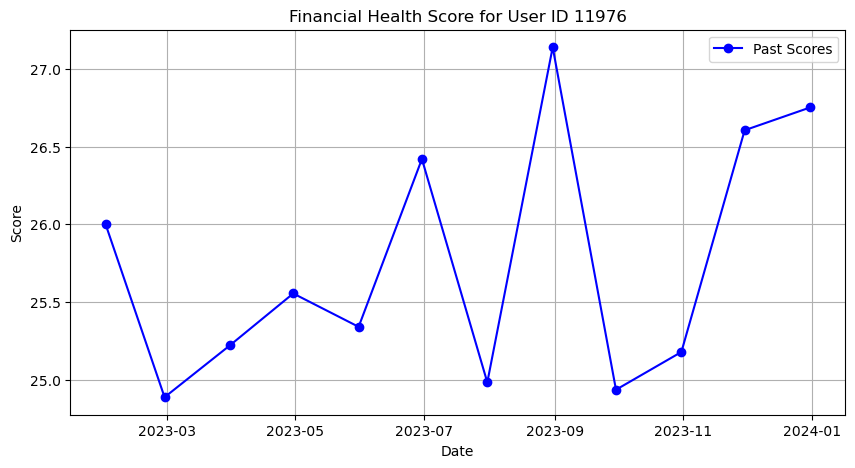

In [16]:
# Example User ID input
user_input = int(input("Enter User ID: "))  # Allow dynamic User ID input

# Call the function to display the financial health chart
plot_financial_health(user_input, financial_history_data, future_predictions_df)

In [17]:
# Save model metrics as a text file
metrics_text = f"""
Model Evaluation Metrics:
-------------------------
Mean Absolute Error (MAE): {mae:.4f}
Mean Squared Error (MSE): {mse:.4f}
Root Mean Squared Error (RMSE): {rmse:.4f}
R² Score: {r2:.4f}
"""

# Write to a .txt file
with open("model_metrics.txt", "w") as f:
    f.write(metrics_text)

print("Model metrics saved successfully as .txt.")

Model metrics saved successfully as .txt.


In [18]:
import pickle

# Save trained XGBoost model
with open("xgboost_fhs_model.pkl", "wb") as f:
    pickle.dump(xgb_model, f)

print("Model saved successfully as .pkl.")

Model saved successfully as .pkl.


In [19]:
original_data.columns

Index(['Income', 'Age', 'Dependents', 'Occupation', 'City_Tier', 'Rent',
       'Loan_Repayment', 'Insurance', 'Groceries', 'Transport', 'Eating_Out',
       'Entertainment', 'Utilities', 'Healthcare', 'Education',
       'Miscellaneous', 'Desired_Savings_Percentage', 'Desired_Savings',
       'Disposable_Income', 'Potential_Savings_Groceries',
       'Potential_Savings_Transport', 'Potential_Savings_Eating_Out',
       'Potential_Savings_Entertainment', 'Potential_Savings_Utilities',
       'Potential_Savings_Healthcare', 'Potential_Savings_Education',
       'Potential_Savings_Miscellaneous', 'Income_Tier', 'Total_Expenses',
       'Overspending_Flag', 'Savings_Efficiency', 'Essential_Expenses',
       'Non_Essential_Expenses', 'Rent_to_Income_Ratio',
       'Groceries_to_Income_Ratio', 'Total_Expenses_to_Income_Ratio',
       'Discretionary_to_Income_Ratio', 'Savings_Target_Efficiency',
       'Expense_Diversity_Index', 'User_ID', 'Debt_to_Income_Ratio'],
      dtype='object')

In [20]:
# Save financial history data to CSV (without modifying original dataset)
financial_history_data.to_csv("financial_history_data.csv", index=False)

print(" Financial history data saved successfully as 'financial_history_data.csv'.")


 Financial history data saved successfully as 'financial_history_data.csv'.


In [21]:
financial_history_data.columns

Index(['User_ID', 'Date', 'Income', 'Disposable_Income', 'Essential_Expenses',
       'Non_Essential_Expenses', 'Total_Expenses_to_Income_Ratio',
       'Desired_Savings_Percentage', 'Savings_Efficiency',
       'Debt_to_Income_Ratio', 'Financial_Health_Score'],
      dtype='object')